# Quantized inverse dynamic for  Go -Explore

In [1]:
import gym_continuous_maze
import numpy as np
from stable_baselines3 import SAC
from toolbox.maze_grid import cumulative_cells

from go_explore.inverse_dynamic_go_explore import GoExploreInverseModel


go_explore = GoExploreInverseModel(SAC, "ContinuousMaze-v0", traj_step=3, count_pow=0.5)
go_explore.explore(20_000)

pygame 2.1.2 (SDL 2.0.18, Python 3.8.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/quentingallouedec/go-explore/go_explore/go_explore.py:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  goal = torch.Tensor(goal).to(device)


Plot an exploration measure.

In [ ]:
import matplotlib.pyplot as plt

archive = go_explore.archive
observations = archive.observations["observation"][: archive.pos]
counts = cumulative_cells(observations)
plt.plot(counts)

[  1.   2.   3. ... 194. 194. 194.]


Sample goals and trajectories. Draw them and store the image into `goals_and_traj.bmp`.

In [ ]:
from toolbox.render_maze import render_and_save

traj = [go_explore.archive.sample_trajectory(count_pow=0.8, step=3)[0] for _ in range(10)]
goals = [go_explore.archive.sample_trajectory(count_pow=0.8)[0][-1] for _ in range(100)]

env = go_explore.model.env.envs[0]
render_and_save(
    all_pos=env.all_pos,
    walls=env.walls,
    filename="goals_and_traj.bmp",
    trajectories=traj,
    goals=goals,
)


Render the latent space and the observation space to see the cells.

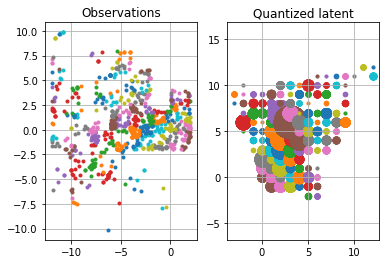

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample = go_explore.archive.sample(1024)
observations = sample.observations["observation"].detach().cpu().numpy()
all_cells = sample.observations["cell"].detach().cpu().numpy()

cells, counts = np.unique(all_cells, return_counts=True, axis=0)

fig, axs = plt.subplots(1, 2)
# Observations
axs[0].grid()
axs[0].set_title("Observations")
axs[0].axis("equal")
for cell in cells:
    axs[0].plot(*observations[(all_cells == cell).all(1)].T, "o", markersize=3)

# Quantized latent
axs[1].grid()
axs[1].set_title("Quantized latent")
axs[1].axis("equal")
for cell, count in zip(cells, counts):
    axs[1].scatter(*all_cells[(all_cells == cell).all(1)].T, s=count * 10)


Test wether the inverse model is accurate.

In [ ]:
# Sample one transition
sample = go_explore.archive.sample(1)
observations = sample.observations["observation"]
next_observations = sample.next_observations["observation"]
actions = sample.actions

# Predict the action
go_explore.inverse_model.eval()
pred_actions = go_explore.inverse_model(observations, next_observations)

# See the result
print("observation\t\t", observations)
print("next observation\t", next_observations)
print("true action\t\t", actions)
print("predicted action\t", pred_actions)


observation		 tensor([[-5.9263,  1.3379]])
next observation	 tensor([[-5.9263,  1.3379]])
true action		 tensor([[-0.7040, -0.8164]])
predicted action	 tensor([[-0.3154, -0.0638]], grad_fn=<AddmmBackward0>)
